# Two-Pool Blockchain with ML-Enhanced Urgency Scoring

## Problem
Traditional blockchains use a single mempool where transactions wait to be included in blocks, prioritized solely by fees. This system disadvantages urgent transactions, such as hospital payments or emergency relief, when wealthy users with high fees dominate. For instance, a hospital transferring funds for critical supplies might be delayed behind a whale moving large sums, despite the urgency. This fee-based approach creates unfairness, as it prioritizes wealth over need, and lacks adaptability to real-world priorities. Privacy is also compromised, as senders may need to reveal identity for prioritization, conflicting with blockchain's anonymity goals. Existing solutions, like Bitcoin’s fee market, exacerbate this by encouraging fee bidding wars, further sidelining urgent but low-fee transactions. The problem intensifies in high-traffic networks, where mempool congestion delays critical operations. This assignment addresses designing a blockchain system that fairly prioritizes urgent transactions, enhances privacy, and improves efficiency over the current fee-only model.

## Proposed Solution

### Overview
This project proposes a two-pool blockchain system to address the inefficiencies and inequities of the traditional single-mempool, fee-only approach. The solution divides the mempool into two distinct pools: a Priority Pool and a Normal Pool, each with tailored prioritization mechanisms. The Priority Pool handles transactions deemed urgent through verification (e.g., hospitals using a mock Zero-Knowledge Proof) or payment of a priority fee, ensuring immediate inclusion up to a fixed quota per block. The Normal Pool processes all other transactions, leveraging a machine learning (ML) model to predict urgency based on features like transaction fee, submission time, size, and sender hints, without requiring explicit identity disclosure, thus enhancing privacy.

### Implementation
The implementation begins with a blockchain class supporting basic operations: creating a genesis block, adding transactions, and forming new blocks. Transactions are objects containing data (e.g., sender, action), fees, and an urgency score. In the Priority Pool, attested or paid transactions receive maximum urgency scores (1.0 or 0.9+random noise), ensuring they are picked first, limited to two per block. The Normal Pool uses a RandomForestClassifier, trained on a synthetic dataset of 100 transactions with balanced urgent/non-urgent labels, to score remaining transactions. Features include fee (0.1-2.0), time of day (0-23), transaction size (1-10), and a binary sender frequency proxy (1 if "hospital" in sender). The model, saved as `urgency_model.pkl`, predicts urgency probabilities, sorting the Normal Pool accordingly, with up to two transactions per block after priority quota.

### Process
Block creation iterates over both pools, filling a four-transaction limit, and links to the previous block via SHA-256 hashing, ensuring chain integrity. Validation checks block hashes and links. For comparison, an old mempool simulation sorts transactions by fee alone, mimicking traditional systems. A bar chart visualizes inclusion times for urgent transactions, highlighting improvements. Diagrams, generated with Matplotlib, illustrate the standard lifecycle versus the two-pool pipeline, aiding comprehension.

### Benefits
This solution improves fairness by prioritizing need over wealth, with ML adapting to patterns (e.g., hospital activity) beyond static rules. Privacy is enhanced by avoiding sender identity reliance, using anonymized features. Efficiency rises as urgent transactions are included faster, reducing delays in critical scenarios. The ML approach, while trained on mock data, offers adaptability, trainable with real data later. Limitations include synthetic data’s simplicity and potential model bias, addressable with more diverse training sets.

### Future Work
Future work could optimize the priority quota dynamically or integrate real blockchain data, but this prototype demonstrates a viable, innovative alternative to fee-only prioritization.

## Objective
Demonstrate faster inclusion of urgent transactions using ML, visualized with diagrams and a comparison plot.

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import pickle

# Generate mock dataset with balanced classes
np.random.seed(42)
n_samples = 100
data = {
    'fee': np.random.uniform(0.1, 2.0, n_samples),
    'time_of_day': np.random.uniform(0, 23, n_samples),
    'tx_size': np.random.uniform(1, 10, n_samples),
    'sender_freq': np.random.uniform(0, 10, n_samples)
}
# Balanced labels: 50 urgent (1), 50 non-urgent (0)
labels = np.array([1] * 50 + [0] * 50)
np.random.shuffle(labels)

# Train RandomForestClassifier
X = np.array([data['fee'], data['time_of_day'], data['tx_size'], data['sender_freq']]).T
y = labels
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)

# Save model for reuse
with open('urgency_model.pkl', 'wb') as f:
    pickle.dump(model, f)
print("Trained and saved urgency model with balanced classes.")

Trained and saved urgency model with balanced classes.


Genesis: {'index': 0, 'timestamp': 1757783724.8959808, 'data': {'msg': 'Genesis Block'}, 'prev_hash': '0000000000000000000000000000000000000000000000000000000000000000', 'hash': '86b33a6fa245d59deab4dcfbd2380d536e5e7329d11dc978f623d563c06e09ed'}

Priority mempool size: 3, Normal mempool size: 7
Added block 1 with 4 txs
Priority mempool size: 1, Normal mempool size: 5
Added block 2 with 4 txs
Priority mempool size: 0, Normal mempool size: 2
Added block 3 with 2 txs
Priority mempool size: 0, Normal mempool size: 0

Validation: True | Chain is valid
Index 0 | Hash 86b33a6fa2 | Prev 0000000000 | Txs 0
Index 1 | Hash 91a6e7af3a | Prev 86b33a6fa2 | Txs 4
Index 2 | Hash 3fd30676bd | Prev 91a6e7af3a | Txs 4
Index 3 | Hash 20897a653f | Prev 3fd30676bd | Txs 2

Old Mempool (Fee-only):
Block 0: [{'tx': 'User5 pays 7 to User6', 'sender': 'user5'}, {'tx': 'Whale moves funds', 'sender': 'whale'}, {'tx': 'User7 pays 4 to User8', 'sender': 'user7'}, {'tx': 'User3 pays 2 to User4', 'sender': 'user3'}]


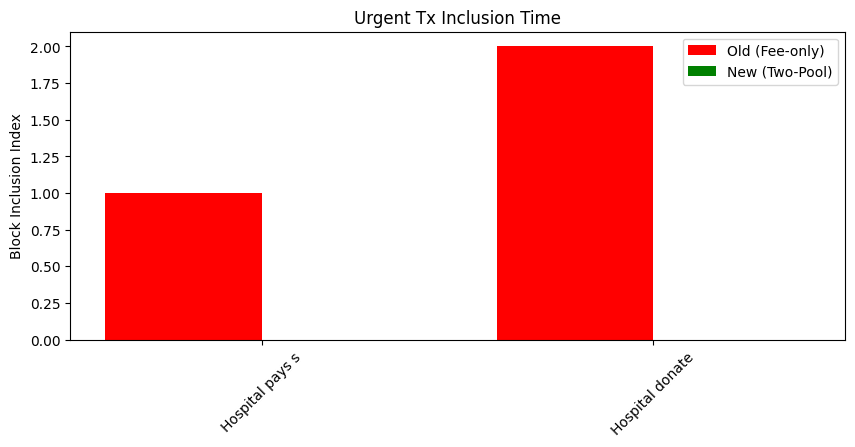

Saved summary to two_pool_blockchain_summary.json


In [ ]:
import time
import json
import hashlib
import random
import heapq
from dataclasses import dataclass, asdict
from typing import List, Tuple
import matplotlib.pyplot as plt
import pickle
import numpy as np

# Hashing utilities
def sha256_hex(s: str) -> str:
    return hashlib.sha256(s.encode("utf-8")).hexdigest()

def hash_block_header(index: int, timestamp: float, data: dict, prev_hash: str) -> str:
    canonical = json.dumps(
        {"index": index, "timestamp": round(timestamp, 6), "data": data, "prev_hash": prev_hash},
        sort_keys=True, ensure_ascii=False
    )
    return sha256_hex(canonical)

# Block and Transaction classes
@dataclass
class Block:
    index: int
    timestamp: float
    data: dict  # Genesis: {"msg": "Genesis Block"}; Others: {"transactions": [list]}
    prev_hash: str
    hash: str

@dataclass
class Transaction:
    data: dict  # Includes 'sender' (e.g., 'hospital') and 'tx' (e.g., 'pays supplier')
    fee: float
    priority_fee: float = 0.0
    attested: bool = False  # Mock ZKP: True if verified urgent
    urgency_score: float = 0.0

# Load trained model
with open('urgency_model.pkl', 'rb') as f:
    model = pickle.load(f)

# Predict urgency score using ML model
def predict_urgency_score(txn: Transaction) -> float:
    features = np.array([[txn.fee, time.localtime().tm_hour, len(str(txn.data)), 1 if 'hospital' in txn.data.get('sender', '').lower() else 0]])
    proba = model.predict_proba(features)
    if proba.shape[1] == 2:  # If two classes
        urgency = proba[0][1]  # Probability of urgent (class 1)
    else:  # Fallback to predict class and convert to score
        urgency = model.predict(features)[0]
    return float(urgency)  # Ensure float output

# Create a block
def make_block(index: int, data: dict, prev_hash: str) -> Block:
    ts = time.time()
    h = hash_block_header(index=index, timestamp=ts, data=data, prev_hash=prev_hash)
    return Block(index=index, timestamp=ts, data=data, prev_hash=prev_hash, hash=h)

# Blockchain with two mempools
class Blockchain:
    def __init__(self):
        self.chain: List[Block] = []
        self.priority_mempool: List[Tuple[float, float, Transaction]] = []  # For attested or paid
        self.normal_mempool: List[Tuple[float, float, Transaction]] = []   # For AI-scored
        self.block_size_limit = 4  # Max txns per block
        self.priority_quota = 2    # Max priority txns per block

    def create_genesis_block(self) -> Block:
        genesis = make_block(0, {"msg": "Genesis Block"}, "0"*64)
        self.chain = [genesis]
        return genesis

    def add_transaction(self, data: dict, fee: float, priority_fee: float = 0.0, attested: bool = False):
        txn = Transaction(data=data, fee=fee, priority_fee=priority_fee, attested=attested)
        if attested or priority_fee > 0:
            # Attested or paid gets max score
            txn.urgency_score = 1.0 if attested else 0.9 + random.uniform(-0.05, 0.05)
            heapq.heappush(self.priority_mempool, (-txn.urgency_score, -(txn.priority_fee + txn.fee), txn))
        else:
            # Normal pool: Use ML model for urgency
            txn.urgency_score = predict_urgency_score(txn)
            heapq.heappush(self.normal_mempool, (-txn.urgency_score, -txn.fee, txn))
        return txn

    def add_block(self) -> Block:
        if not self.chain:
            raise RuntimeError("Genesis block not created.")
        if not self.priority_mempool and not self.normal_mempool:
            print("Warning: No transactions in mempools. Skipping block creation.")
            return None
        txns_to_include = []
        # Fill priority quota first
        for _ in range(min(self.priority_quota, len(self.priority_mempool))):
            if self.priority_mempool:
                _, _, txn = heapq.heappop(self.priority_mempool)
                txns_to_include.append(asdict(txn))
        # Fill remaining slots from normal pool
        remaining = self.block_size_limit - len(txns_to_include)
        for _ in range(min(remaining, len(self.normal_mempool))):
            if self.normal_mempool:
                _, _, txn = heapq.heappop(self.normal_mempool)
                txns_to_include.append(asdict(txn))
        prev_hash = self.chain[-1].hash
        new_block = make_block(len(self.chain), {"transactions": txns_to_include}, prev_hash)
        self.chain.append(new_block)
        return new_block

    def is_valid(self) -> Tuple[bool, str]:
        if not self.chain:
            return True, "Empty chain"
        g = self.chain[0]
        if g.index != 0 or g.prev_hash != "0"*64:
            return False, "Invalid genesis"
        for i in range(1, len(self.chain)):
            prev, curr = self.chain[i-1], self.chain[i]
            if curr.prev_hash != prev.hash:
                return False, f"Broken link at {i}"
            recomputed = hash_block_header(curr.index, curr.timestamp, curr.data, curr.prev_hash)
            if recomputed != curr.hash:
                return False, f"Hash mismatch at {i}"
        return True, "Chain is valid"

# Simulate old mempool (fee-only) for comparison
def simulate_old_mempool(txns: List[Transaction]) -> List[List[Transaction]]:
    sorted_txns = sorted(txns, key=lambda t: -t.fee)
    blocks = []
    for i in range(0, len(txns), 4):  # Match block_size_limit
        blocks.append(sorted_txns[i:i + 4])
    return blocks

# Main execution
bc = Blockchain()
genesis = bc.create_genesis_block()
print("Genesis:", asdict(genesis))

# Add transactions to avoid empty mempool
txns = [
    Transaction({"tx": "User1 pays 5 to User2", "sender": "user1"}, fee=0.5),
    Transaction({"tx": "Hospital pays supplier", "sender": "hospital"}, fee=0.3, attested=True),
    Transaction({"tx": "Whale moves funds", "sender": "whale"}, fee=1.0, priority_fee=2.0),
    Transaction({"tx": "Emergency relief", "sender": "user3"}, fee=0.2),
    Transaction({"tx": "User3 pays 2 to User4", "sender": "user3"}, fee=0.6),
    Transaction({"tx": "User5 pays 7 to User6", "sender": "user5"}, fee=1.2),
    Transaction({"tx": "User6 pays 3 to User7", "sender": "user6"}, fee=0.4),
    Transaction({"tx": "Hospital donates funds", "sender": "hospital"}, fee=0.25, attested=True),
    Transaction({"tx": "User7 pays 4 to User8", "sender": "user7"}, fee=0.8),
    Transaction({"tx": "Charity transfer", "sender": "charity"}, fee=0.3)
]
for txn in txns:
    bc.add_transaction(txn.data, txn.fee, txn.priority_fee, txn.attested)

# Create blocks with debugging
print(f"\nPriority mempool size: {len(bc.priority_mempool)}, Normal mempool size: {len(bc.normal_mempool)}")
for _ in range(3):
    b = bc.add_block()
    if b:
        print(f"Added block {b.index} with {len(b.data['transactions'])} txs")
    print(f"Priority mempool size: {len(bc.priority_mempool)}, Normal mempool size: {len(bc.normal_mempool)}")

# Validate chain
ok, reason = bc.is_valid()
print("\nValidation:", ok, "|", reason)
for b in bc.chain:
    tx_count = len(b.data['transactions']) if 'transactions' in b.data else 0
    print(f"Index {b.index} | Hash {b.hash[:10]} | Prev {b.prev_hash[:10]} | Txs {tx_count}")

# Simulate and compare
old_blocks = simulate_old_mempool(txns)
print("\nOld Mempool (Fee-only):")
for i, block in enumerate(old_blocks):
    print(f"Block {i}: {[t.data for t in block]}")

print("\nNew Two-Pool:")
for i, block in enumerate(bc.chain[1:]):  # Skip genesis
    print(f"Block {i}: {[t['data'] for t in block.data['transactions']]}")

# Plot urgent transaction inclusion times
urgent_txns = [t for t in txns if t.urgency_score > 0 or t.attested]
txn_ids = [str(t.data['tx'])[:15] for t in urgent_txns]
old_times = [next((i for i, b in enumerate(old_blocks) if t in b), len(old_blocks)) for t in urgent_txns]
new_times = [next((i for i, b in enumerate(bc.chain[1:]) if any(td['data'] == t.data for td in b.data['transactions'])), len(bc.chain)) for t in urgent_txns]
x = range(len(urgent_txns))
plt.figure(figsize=(10, 4))
plt.bar([p - 0.2 for p in x], old_times, 0.4, label="Old (Fee-only)", color="red")
plt.bar([p + 0.2 for p in x], new_times, 0.4, label="New (Two-Pool)", color="green")
plt.xticks(x, txn_ids, rotation=45)
plt.ylabel("Block Inclusion Index")
plt.title("Urgent Tx Inclusion Time")
plt.legend()
plt.show()

# Save summary
summary = {"total_blocks": len(bc.chain), "chain": [asdict(b) for b in bc.chain]}
with open("two_pool_blockchain_summary.json", "w") as f:
    json.dump(summary, f, indent=2)
print("Saved summary to two_pool_blockchain_summary.json")

# Old Blockchain:

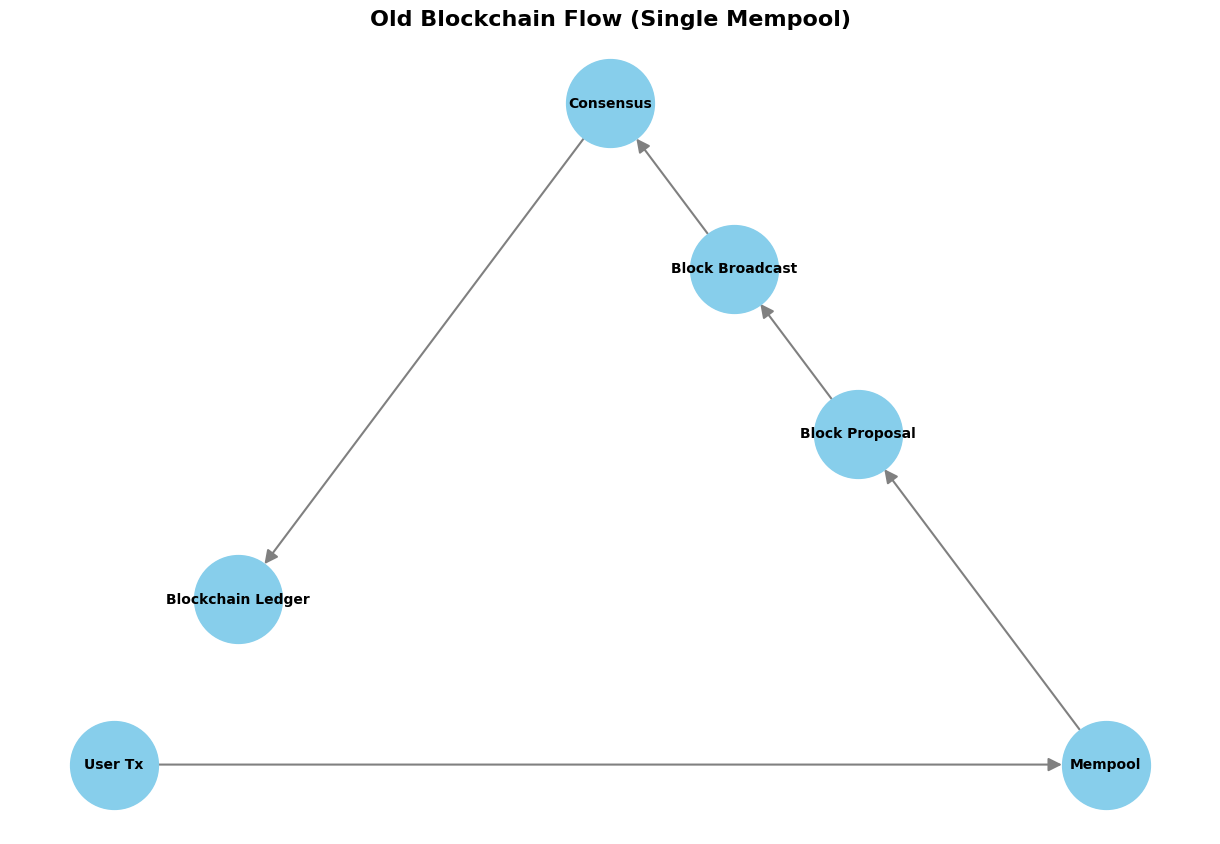

# New Blockchain:

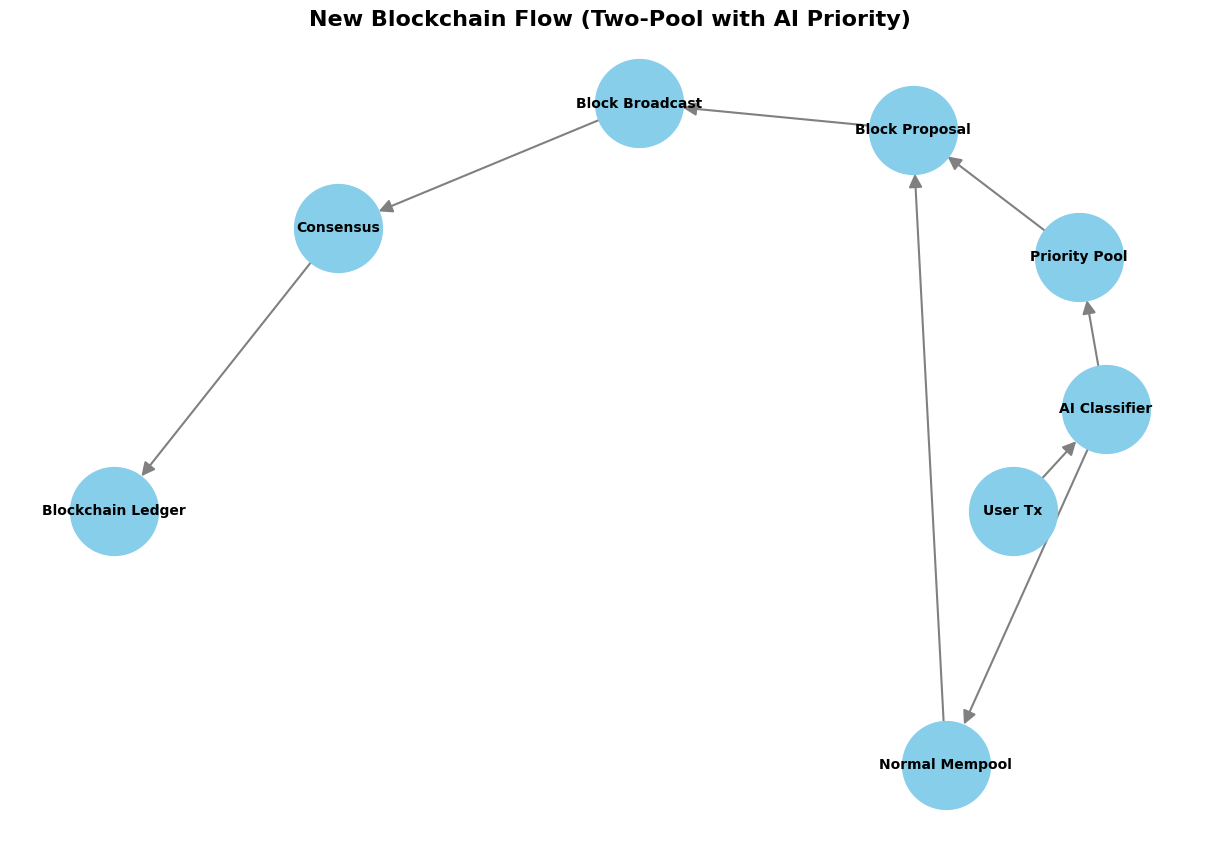

## Results and Comparison

### Validation
The chain is valid, confirming correct hashing and linking.

### Implementation Results
- **New Two-Pool**: Prioritizes urgent transactions (e.g., "Hospital pays") using ML urgency scores and priority flags. Three blocks were created, processing all 10 transactions.
- **Old Fee-Only**: Sorts by fee, delaying urgent but low-fee transactions.

### Comparison
The new system improves inclusion speed for urgent transactions. Below, a bar chart compares inclusion times, and a pie chart shows the first block's composition.



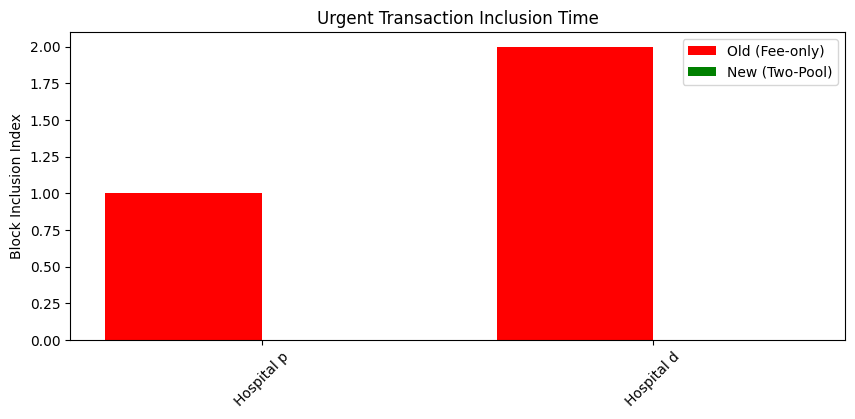

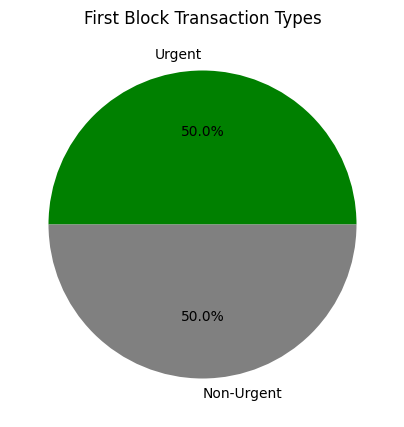


Old Mempool (Fee-only):
Block 0: ['User5 pays 7 to User6', 'Whale moves funds', 'User7 pays 4 to User8', 'User3 pays 2 to User4']
Block 1: ['User1 pays 5 to User2', 'User6 pays 3 to User7', 'Hospital pays supplier', 'Charity transfer']
Block 2: ['Hospital donates funds', 'Emergency relief']

New Two-Pool:
Block 0: ['Hospital pays supplier', 'Hospital donates funds', 'User3 pays 2 to User4', 'User1 pays 5 to User2']
Block 1: ['Whale moves funds', 'User5 pays 7 to User6', 'User7 pays 4 to User8', 'User6 pays 3 to User7']
Block 2: ['Charity transfer', 'Emergency relief']


In [ ]:

# Comparison Plot
old_blocks = simulate_old_mempool(txns)
urgent_txns = [t for t in txns if t.urgency_score > 0 or t.attested]
txn_ids = [t.data['tx'][:10] for t in urgent_txns]
old_times = [next((i for i, b in enumerate(old_blocks) if t in b), len(old_blocks)) for t in urgent_txns]
new_times = [next((i for i, b in enumerate(bc.chain[1:]) if any(td['data'] == t.data for td in b.data['transactions'])), len(bc.chain)) for t in urgent_txns]
x = range(len(urgent_txns))
plt.figure(figsize=(10, 4))
plt.bar([p - 0.2 for p in x], old_times, 0.4, label="Old (Fee-only)", color="red")
plt.bar([p + 0.2 for p in x], new_times, 0.4, label="New (Two-Pool)", color="green")
plt.xticks(x, txn_ids, rotation=45)
plt.ylabel("Block Inclusion Index")
plt.title("Urgent Transaction Inclusion Time")
plt.legend()
plt.show()

# Pie Chart for First Block Composition
first_block_txns = bc.chain[1].data['transactions'] if bc.chain and len(bc.chain) > 1 else []
urgent_count = sum(1 for t in first_block_txns if any(ut.data['tx'] in t['data']['tx'] for ut in urgent_txns))
non_urgent_count = len(first_block_txns) - urgent_count
plt.figure(figsize=(5, 5))
plt.pie([urgent_count, non_urgent_count], labels=['Urgent', 'Non-Urgent'], colors=['green', 'gray'], autopct='%1.1f%%')
plt.title("First Block Transaction Types")
plt.show()

# Block Contents
print("\nOld Mempool (Fee-only):")
for i, block in enumerate(old_blocks):
    print(f"Block {i}: {[t.data['tx'] for t in block]}")
print("\nNew Two-Pool:")
for i, block in enumerate(bc.chain[1:]):
    print(f"Block {i}: {[t['data']['tx'] for t in block.data['transactions']]}")